## Data Engineering Capstone Project

#### Project Summary
Being a resident of New York City, I decided to look up some datasets put out for it. In doing so, I found an evictions dataset. In combining the neighbohood data with this dataset, I can calculate the number evictions based on neighborhood. This will actually be the combining of data from three seperate datasets.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [ ]:
! pip install sodapy

In [31]:
# Do all imports and installs here
import pandas as pd
from sodapy import Socrata
import requests
import random
from IPython.display import Image
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

### Step 1: Scope the Project and Gather Data

#### Scope 
Using a combination of Python, Spark, Pandas, and Requests, I will grab datasets by ingesting CSV, Excel, and JSON files locally and via API calls. From there I will clean the data and remove columns that will not be useful in aggregating evictions by geographic dimansions.
#### Describe and Gather Data 
The datasets came from a variety of places. This includes NYC's Open Data site, where the city holds a lot of its collected data from a variety of sources. I also found some mapping data from UDS mapper to help mapping postal zip codes to census created zcta numbers.

In [2]:
# Creating the spark session/context
spark = SparkSession \
        .builder \
        .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0") \
        .getOrCreate()

sc = spark.sparkContext

### NYC Eviction Dataset
Using NYC's open data website, I found a dataset of evictions the city has collected. The dataset can be found [HERE](https://data.cityofnewyork.us/City-Government/Evictions/6z8x-wfk4). Using the API, I grabbed the data. A sample can be found below.

In [3]:
# Grabbing evicion data and converting to pandas to preview
client = Socrata("data.cityofnewyork.us", None)
results = client.get_all("6z8x-wfk4")
evict_json = sc.parallelize(results)
evict_schema = StructType([
        StructField('court_index_number', StringType()),
        StructField('docket_number', StringType()),
        StructField('eviction_address', StringType()),
        StructField('eviction_apt_num', StringType()),
        StructField('executed_date', DateType()),
        StructField('marshal_first_name', StringType()),
        StructField('marshal_last_name', StringType()),
        StructField('residential_commercial_ind', StringType()),
        StructField('borough', StringType()),
        StructField('eviction_zip', StringType())
        ])
df_evict = spark.read.schema(evict_schema).json(evict_json)
df_evict.limit(10).toPandas()

,court_index_number,docket_number,eviction_address,eviction_apt_num,executed_date,marshal_first_name,marshal_last_name,residential_commercial_ind,borough,eviction_zip
0,R 50729/18,070266,21 SHERADEN AVE. A/K/A 17-25 SHERADEN,5A,2018-06-01,Steven,Powell,Residential,STATEN ISLAND,10314
1,63907/17,6167,403 HOWARD AVENUE - APT. #307,307,2017-10-20,Robert,Renzulli,Residential,BROOKLYN,11233
2,B56588/18B,093376,1200 COLLEGE AVENUE,3M,2019-07-18,Ileana,Rivera,Residential,BRONX,10456
3,51795/17,291978,48-25 46TH STREET,5E,2017-04-12,George,Essock,Residential,QUEENS,11377
4,K70703/18,090175,611 GATES AVENUE,1A,2018-11-08,Ileana,Rivera,Residential,BROOKLYN,11221
5,92653/16,073400,2440 EAST 29TH ST,4D,2018-02-02,Justin,Grossman,Residential,BROOKLYN,11235
6,58306/17,062353,565 EAST 80TH STREET,3RD FLOOR,2017-10-16,Justin,Grossman,Residential,BROOKLYN,11236
7,B61702/18,093896,2033 VALENTINE AVE,52A,2019-03-12,Ileana,Rivera,Residential,BRONX,10457
8,87810/17,14275,65 MACON STREET,2F,2018-01-09,Edward,Guida,Residential,BROOKLYN,11216
9,K51450/17,077730,626 EAST 16TH STREET,1,2017-09-12,Ileana,Rivera,Residential,BROOKLYN,11226


### Covid data
I was initially going to try to use covid data from the city, however decided not to since it is more of an aggregate table rather than single events. However, it is still useful in naming NYC neighborhoods via ZCTA5. The dataset can be found [HERE](https://github.com/nychealth/coronavirus-data/blob/master/data-by-modzcta.csv).

In [4]:
# Getting the covid data
covid_schema = StructType([
        StructField('modified_zcta', StringType()),
        StructField('neighborhood_name', StringType()),
        StructField('borough_group', StringType()),
        StructField('covid_case_count', IntegerType()),
        StructField('covid_case_rate', DoubleType()),
        StructField('pop_denominator', DoubleType()),
        StructField('covid_death_count', IntegerType()),
        StructField('covid_death_rate', DoubleType()),
        StructField('percent_positive', DoubleType()),
        StructField('total_covid_tests', IntegerType())
        ])
df_covid = spark.read.schema(covid_schema).csv('data-by-modzcta.csv')
df_covid.limit(10).toPandas()

,modified_zcta,neighborhood_name,borough_group,covid_case_count,covid_case_rate,pop_denominator,covid_death_count,covid_death_rate,percent_positive,total_covid_tests
0,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,Chelsea/NoMad/West Chelsea,Manhattan,404.0,1714.55,23563.03,24.0,101.85,8.72,4635.0
2,10002,Chinatown/Lower East Side,Manhattan,1158.0,1508.69,76755.41,158.0,205.85,12.17,9514.0
3,10003,East Village/Gramercy/Greenwich Village,Manhattan,492.0,914.47,53801.62,34.0,63.20,6.63,7420.0
4,10004,Financial District,Manhattan,35.0,958.74,3650.61,1.0,27.39,6.93,505.0
5,10005,Financial District,Manhattan,72.0,857.54,8396.11,2.0,23.82,6.39,1126.0
6,10006,Financial District,Manhattan,32.0,925.45,3457.77,0.0,0.00,6.17,519.0
7,10007,TriBeCa,Manhattan,66.0,800.03,8249.73,3.0,36.36,5.36,1231.0
8,10009,Alphabet City/East Village/Stuyvesant Town-Coo...,Manhattan,753.0,1281.75,58747.99,69.0,117.45,8.79,8563.0
9,10010,Flatiron/Gramercy/Kips Bay,Manhattan,289.0,892.75,32371.86,19.0,58.69,5.72,5052.0


### Zip to ZCTA5 data
Zip codes are primarily a device used by the postal office for delivering mail. Because of this, zip codes are not necessarily geographical areas seperated from one another. US Census data created ZCTAs for the latter situation. Though they did not release a map for zip code to ZCTA, UDS Mapper has created one. The dataset can be found [HERE](https://www.udsmapper.org/zcta-crosswalk.cfm).

In [5]:
# Getting Zip to zcta data. Will use pandas to read .xlsx file first
zip_schema = StructType([
        StructField('zip_code', StringType()),
        StructField('po_name', StringType()),
        StructField('state', StringType()),
        StructField('zip_type', StringType()),
        StructField('zcta', StringType()),
        StructField('zip_join_type', StringType())
        ])
zip_pandas = pd.read_excel('zip_to_zcta_2019.xlsx').astype(str)
df_zip = spark.createDataFrame(zip_pandas)
df_zip.limit(10).toPandas()

,ZIP_CODE,PO_NAME,STATE,ZIP_TYPE,ZCTA,zip_join_type
0,501,Holtsville,NY,Post Office or large volume customer,11742,Spatial join to ZCTA
1,544,Holtsville,NY,Post Office or large volume customer,11742,Spatial join to ZCTA
2,601,Adjuntas,PR,Zip Code Area,00601,Zip Matches ZCTA
3,602,Aguada,PR,Zip Code Area,00602,Zip Matches ZCTA
4,603,Aguadilla,PR,Zip Code Area,00603,Zip Matches ZCTA
5,604,Aguadilla,PR,Post Office or large volume customer,00603,Spatial join to ZCTA
6,605,Aguadilla,PR,Post Office or large volume customer,00603,Spatial join to ZCTA
7,606,Maricao,PR,Zip Code Area,00606,Zip Matches ZCTA
8,610,Anasco,PR,Zip Code Area,00610,Zip Matches ZCTA
9,611,Angeles,PR,Post Office or large volume customer,00641,Spatial join to ZCTA


### Step 2: Explore and Assess the Data
#### Explore the Data 
To get a grasp of the data, we will look at the shape of each dataset, then look for duplicates and NULLs.


In [6]:
# Getting shapes
print(f'Eviction dataset has {len(df_evict.columns)} columns and {df_evict.count()} rows')
print(f'Covid dataset has {len(df_covid.columns)} columns and {df_covid.count()} rows')
print(f'Zip Code dataset has {len(df_zip.columns)} columns and {df_zip.count()} rows')

Eviction dataset has 10 columns and 66323 rows
Covid dataset has 10 columns and 178 rows
Zip Code dataset has 6 columns and 41107 rows


In [7]:
# Counting Duplicates
print(f'Eviction dataset has {df_evict.count() - df_evict.dropDuplicates().count()} duplicates')
print(f'Covid dataset has {df_covid.count() - df_covid.dropDuplicates().count()} duplicates')
print(f'Zip Code dataset has {df_zip.count() - df_zip.dropDuplicates().count()} duplicates')

Eviction dataset has 22 duplicates
Covid dataset has 0 duplicates
Zip Code dataset has 0 duplicates


In [8]:
# Getting null counts
evict_null = df_evict.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df_evict.columns])
print('Null Count (by column) for the evict dataset')
evict_null.limit(1).toPandas()

Null Count (by column) for the evict dataset


,court_index_number,docket_number,eviction_address,eviction_apt_num,executed_date,marshal_first_name,marshal_last_name,residential_commercial_ind,borough,eviction_zip
0,0,0,0,10916,0,0,0,0,0,0


In [9]:
covid_null = df_covid.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df_covid.columns])
print('Null Count (by column) for the covid dataset')
covid_null.limit(1).toPandas()

Null Count (by column) for the covid dataset


,modified_zcta,neighborhood_name,borough_group,covid_case_count,covid_case_rate,pop_denominator,covid_death_count,covid_death_rate,percent_positive,total_covid_tests
0,1,1,1,1,1,1,1,1,1,1


In [10]:
zip_null = df_zip.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df_zip.columns])
print('Null Count (by column) for the zip code dataset')
zip_null.limit(1).toPandas()

Null Count (by column) for the zip code dataset


,ZIP_CODE,PO_NAME,STATE,ZIP_TYPE,ZCTA,zip_join_type
0,0,0,0,0,0,0


### Data cleanliness
Only the eviction dataset has duplicates. This totals 22 out of a 66,323, which is not a significant amount and is easily removed. This dataset also has several null values in the `eviction_apt_num` column, which makes sense as not all addresses have apartment numbers.

The covid dataset has one row full of nulls, which is seen above in the first row. This is likely from the conversion and is also an east fix.

The zip code data has no duplicates or null values.

#### Cleaning Steps
Document steps necessary to clean the data

In [11]:
# Removing duplicates and null rows. Will perform a test to make sure only those rows are removed.
# This means an evict_df count of 66,323 - 22 (66,301) and a covid count of 178 - 1 (177)
df_evict = df_evict.dropDuplicates()
df_covid = df_covid.dropDuplicates()

print(f'Eviction dataset has {df_evict.count()} rows')
print(f'Covid dataset has {df_covid.count()} rows')

Eviction dataset has 66301 rows
Covid dataset has 178 rows


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
The data model will consist of 3 tables, including a time table we will create in spark from the evictions date column. The model will look as follows:


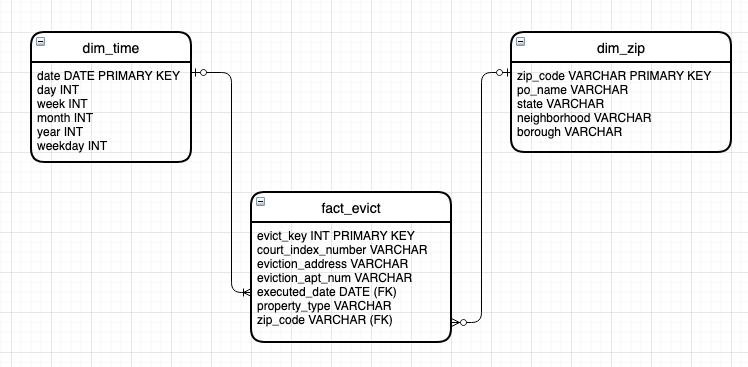

In [12]:
Image("img/ERD.png")

#### 3.2 Mapping Out Data Pipelines
To get here, we will need to 
- Create a `fact_evict` table from eviction data, while adding an evict_key column
- Create a `dim_zip` table using data from the zip_code and covid dataset
- Create a `dim_time` dataset from the eviction data and use Spark functions to create more date-based columns

The `dim_zip` is intentionally denormalized to avoid several smaller tables joined on zip code for queries.

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [41]:
# Creating fact_evict table

#creating a key column by concatenating a random integer and the date column
#df_evict_wkey = df_evict.withColumn('date_string', df_evict.executed_date.cast('string'))
#df_evict_wkey = df_evict_wkey.withColumn('date_key', F.regexp_replace(df_evict_wkey.date_string, '-',''))
#random_udf = F.udf(lambda: random.randint(1000, 9999), IntegerType())
#df_evict_wkey = df_evict_wkey.withColumn('evict_key', F.concat(random_udf(), df_evict_wkey.date_key))
df_evict_wkey = df_evict.withColumn('evict_key', F.monotonically_increasing_id())

# Final table
fact_evict = df_evict_wkey.select(df_evict_wkey.evict_key, df_evict_wkey.docket_number,
                                  df_evict_wkey.eviction_address, df_evict_wkey.eviction_apt_num,
                                  df_evict_wkey.executed_date, df_evict_wkey.residential_commercial_ind.alias('property_type'),
                                  df_evict_wkey.eviction_zip.alias('zip_code'))
fact_evict.limit(10).toPandas()

,evict_key,docket_number,eviction_address,eviction_apt_num,executed_date,property_type,zip_code
0,0,387596,2463 TIEBOUT AVENUE,51,2018-04-17,Residential,10458
1,1,151693,73 HILL STREET (2ND FLOOR APT.),None,2017-05-02,Residential,11208
2,2,345783,1046 COLLEGE AVENUE,2ND FLOOR,2018-09-05,Residential,10456
3,3,395166,2024 BENEDICT AVENUE,4H,2018-10-30,Residential,10462
4,4,21382,1470 BUSHWICK AVENUE,3R,2019-02-22,Residential,11207
5,5,055485,505 W 162ND ST A/K/ A 1045 ST. NICHOLAS,STORE #3,2017-03-02,Commercial,10032
6,6,018981,608 FLATBUSH AVE IN THE CELLAR-B3,None,2019-10-21,Residential,11225
7,7,075981,11 RICHARD LANE FRONT RIGHT ENT.,None,2017-06-22,Residential,10314
8,8,072206,275 KOSCIUSZKO ST,4J,2017-12-08,Residential,11221
9,9,360267,1458 WEBSTER AVENUE,06E,2017-11-01,Residential,10456


In [14]:
# Creating dim_zip table
zip_small = df_zip.select('zip_code', 'po_name', 'state', 'zcta')
covid_neigh = df_covid.select('modified_zcta', 'neighborhood_name', 'borough_group')
dim_zip = covid_neigh.join(zip_small, zip_small.zcta == covid_neigh.modified_zcta)
dim_zip = dim_zip.select(dim_zip.zip_code, dim_zip.po_name, dim_zip.state,
                         dim_zip.neighborhood_name.alias('neighborhood'), dim_zip.borough_group.alias('borough')).distinct()
dim_zip.limit(10).toPandas()

,zip_code,po_name,state,neighborhood,borough
0,10026,New York,NY,Central Harlem (South),Manhattan
1,10126,New York,NY,East Midtown,Manhattan
2,11208,Brooklyn,NY,Cypress Hills/East New York,Brooklyn
3,11426,Bellerose,NY,Bellerose,Queens
4,10164,New York,NY,East Midtown/Murray Hill,Manhattan
5,10129,New York,NY,Hell's Kitchen/Midtown Manhattan,Manhattan
6,11423,Hollis,NY,Hollis/Holliswood,Queens
7,10308,Staten Island,NY,Great Kills,Staten Island
8,10314,Staten Island,NY,Bloomfield/Freshkills Park,Staten Island
9,10472,Bronx,NY,Soundview,Bronx


In [42]:
# Creating the dim_time table
date_column = fact_evict.select(fact_evict.executed_date.alias('date')).distinct()
dim_time = date_column.withColumn('day', F.dayofmonth(date_column.date)) \
                      .withColumn('week', F.weekofyear(date_column.date)) \
                      .withColumn('month', F.month(date_column.date)) \
                      .withColumn('year', F.year(date_column.date)) \
                      .withColumn('weekday', F.dayofweek(date_column.date))
dim_time.limit(10).toPandas()

,date,day,week,month,year,weekday
0,2017-09-11,11,37,9,2017,2
1,2017-08-11,11,32,8,2017,6
2,2018-08-10,10,32,8,2018,6
3,2019-06-04,4,23,6,2019,3
4,2019-05-08,8,19,5,2019,4
5,2018-06-06,6,23,6,2018,4
6,2020-01-21,21,4,1,2020,3
7,2019-11-18,18,47,11,2019,2
8,2017-01-06,6,1,1,2017,6
9,2019-11-01,1,44,11,2019,6


#### 4.2 Data Quality Checks
We will make row counts to ensure no data was lost. The following should match:
- `fact_evict` should match the number from the evictions table, with duplicates dropped
- `dim_time` should match the number of unique executed_date columns from the `fact_evict` table

We will also check if distinct keys match number of records

`dim_zip` will not have a number of records we can check, since multiple zip codes can/will match to a zcta. 

In [43]:
# Perform quality checks here
print(f'fact_evict records should be {df_evict.count()} and it totals {fact_evict.count()}')
print(f'dim_time records should be {df_evict.select("executed_date").distinct().count()} and it totals {dim_time.count()}')

fact_evict records should be 66301 and it totals 66301
dim_time records should be 782 and it totals 782


In [ ]:
# Primary key checks
print(f'fact_evict PKs should be {fact_evict.count()} and it totals {fact_evict.select("evict_key").distinct().count()}')
print(f'dim_zip records should be {dim_zip.count()} and it totals {dim_zip.select("zip_code").distinct().count()}')
print(f'dim_time records should be {dim_time.count()} and it totals {dim_time.select("date").distinct().count()}')

fact_evict PKs should be 66301 and it totals 66301
dim_zip records should be 263 and it totals 263


#### 4.3 Data dictionary 

#### **fact_evict**
- **evict_key** Primary key made from the docket_number and date string
- **court_index_number** Number assigned by the court that has jurisdiction over the landlord/tenant proceedings
- **eviction_address** Identifies the street and building number where an eviction is pending or has been completed
- **eviction_apt_num** Identifies the unit within the building where an eviction is pending or has been completed
- **executed_date** The date that evictions have been executed
- **property_type** Identifies the property type where the eviction is pending or has been completed
- **zip_code** Identifies the NYC zip code where the eviction is pending or has been completed

#### **dim_zip**
- **zip_code** Primary Key, identifies the NYC zip code where the eviction is pending or has been completed
- **po_name** Post office name
- **state** State name
- **neighborhood** NYC neighborhood name
- **borough** NYC borough

#### **dim_time**
- **date** Primary Key, date (no time)
- **day** Integer day of month
- **week** Integer week of year
- **month** Integer month of year
- **year** Integer year
- **weekday** Integer day of the week


#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.

### Project Rationale
I decided to use Spark in case there were a large number of records and the project would be able to scale easily. But also, I wanted to get more practice with it. 

### Data Update
Normally I would propose that the data be updated every month. There is not so much data that it would be hard for the dataset to get appended. However, due to covid, evictions are not happening in the city, so I would wait some time as there is no new data being produced.

### If data were increased by 100x
I think spark is well equipped to handle this larger dataset. However, I would look more at how the data is skewed, as something that large has a high chance of any skew causing it to slow down and run inefficiently. In addition, I would look into additional resources, like more clusters, to help with the workload.

### Data needs to be accessed by 100+ people
If its for analytical purposes, I would look into a large Redshift cluster that can scale to that kind of requests and CPU resources. However, if for more transactional requests, I would look into a denormalized NoSQL solution. This would be quicker for queries and require less resources. If its both, I would look into creating data marts.